## Imports

In [1]:
## Imports
import numpy as np
import pickle
import PIL
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import style
style.use('fivethirtyeight')
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
import scipy.stats as sps

PIL.Image.MAX_IMAGE_PIXELS = 268435460

print("#### Import successfull ####")

#### Import successfull ####


## Loading data

In [2]:
## Preparation

data_array = np.load("total_classification.npy", allow_pickle=True)
print("Shape:", data_array.shape)

## Panda dataframe for using labels instead of column numbers
dataset = pd.DataFrame(data_array, columns = ['Pixel val', 'Gauss1', 'Gauss2', 'Gauss3', 'Gauss4', 'Label'])

x_train, x_val, y_train, y_val = train_test_split(data_array[:, :-1], data_array[:, -1], random_state=0)
print(x_train.shape)


Shape: (88366950, 6)
(66275212, 5)


## Method 1: Boosting via code

Plotting...
Iterating: 0
initialization done...
Running fit() ....
Iterating: 1
initialization done...
Running fit() ....
Running iteration: 0
The Accuracy of the 1. model is :  84.42288774253271 %
The missclassification rate is:  15.577112257467299 %
Iterating: 2
initialization done...
Running fit() ....
Running iteration: 0
The Accuracy of the 1. model is :  84.42288774253271 %
The missclassification rate is:  15.577112257467299 %
Running iteration: 1
The Accuracy of the 2. model is :  31.055282546246076 %
The missclassification rate is:  68.94471745375392 %
Iterating: 3
initialization done...
Running fit() ....
Running iteration: 0
The Accuracy of the 1. model is :  84.42288774253271 %
The missclassification rate is:  15.577112257467299 %
Running iteration: 1
The Accuracy of the 2. model is :  31.055282546246076 %
The missclassification rate is:  68.94471745375392 %
Running iteration: 2
The Accuracy of the 3. model is :  84.14126548443733 %
The missclassification rate is:  15.858734

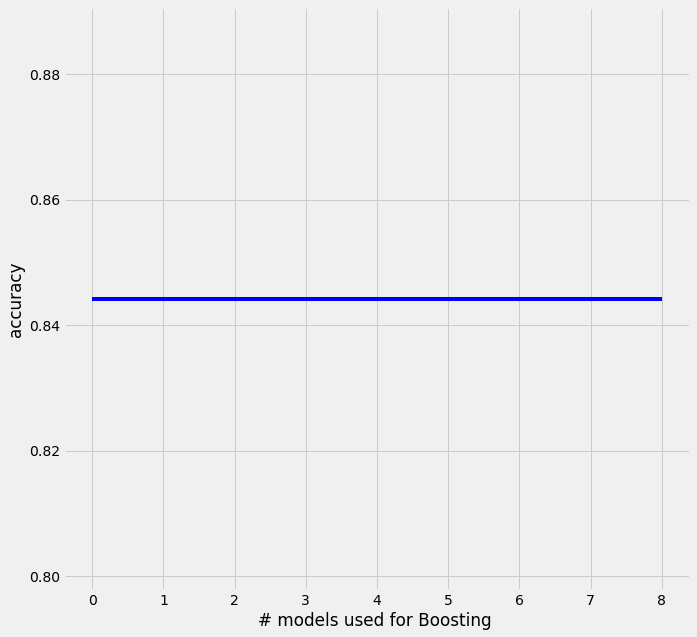

In [5]:
class Boosting:

    def __init__(self,dataset,T, test_dataset):
        self.dataset = dataset
        self.T = T
        self.test_dataset = test_dataset
        self.alphas = None
        self.models = None
        self.accuracy = []
        self.predictions = None
        
        print("initialization done...")
    
    def fit(self):
        # Set the descriptive features and the target feature
        X = self.dataset.drop(['Label'],axis=1)
        Y = self.dataset['Label'].where(self.dataset['Label']==1,-1)

        # Initialize the weights of each sample with wi = 1/N and create a dataframe in which the evaluation is computed
        Evaluation = pd.DataFrame(Y.copy())
        Evaluation['weights'] = 1/len(self.dataset) # Set the initial weights w = 1/N
        

        # Run the boosting algorithm by creating T "weighted models"
        
        alphas = [] 
        models = []
        
        print("Running fit() ....")
        
        
        for t in range(self.T):

            # Training small trees on the errors of the ""main"" model
            Tree_model = DecisionTreeClassifier(criterion="entropy",max_depth=1) # max depth on 1 makes a smoll tree

            model = Tree_model.fit(X,Y,sample_weight=np.array(Evaluation['weights'])) 

            models.append(model)
            predictions = model.predict(X)
            score = model.score(X,Y)

            # Add values to the Evaluation DataFrame
            Evaluation['predictions'] = predictions
            Evaluation['evaluation'] = np.where(Evaluation['predictions'] == Evaluation['Label'],1,0)
            Evaluation['misclassified'] = np.where(Evaluation['predictions'] != Evaluation['Label'],1,0)

            # Calculate the misclassification rate and accuracy
            accuracy = sum(Evaluation['evaluation'])/len(Evaluation['evaluation'])
            misclassification = sum(Evaluation['misclassified'])/len(Evaluation['misclassified'])


            # Caclulate the error
            err = np.sum(Evaluation['weights']*Evaluation['misclassified'])/np.sum(Evaluation['weights'])
 
   
            # Calculate the alpha values
            alpha = np.log((1-err)/err)
            alphas.append(alpha)

            Evaluation['weights'] *= np.exp(alpha*Evaluation['misclassified'])

            print("Running iteration:", t)
            print('The Accuracy of the {0}. model is : '.format(t+1),accuracy*100,'%')
            print('The missclassification rate is: ',misclassification*100,'%')
        
        self.alphas = alphas
        self.models = models
            
    def predict(self):
        X_test = self.test_dataset.drop(['Label'],axis=1).reindex(range(len(self.test_dataset)))
        Y_test = self.test_dataset['Label'].reindex(range(len(self.test_dataset))).where(self.dataset['Label']==1,-1)
        
        accuracy = []
        predictions = []
        
        for alpha, model in zip(self.alphas,self.models):
            prediction = alpha * model.predict(X_test)
            predictions.append(prediction)
            self.accuracy.append(np.sum(np.sign(np.sum(np.array(predictions),axis=0))==Y_test.values)/len(predictions[0]))
        self.predictions = np.sign(np.sum(np.array(predictions),axis=0))

        
## Finalizing stage:

print("Plotting...")
number_of_base_learners = 10

fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)


for i in range(number_of_base_learners):
    print("Iterating:", i)
    model = Boosting(dataset,i,dataset)
    model.fit()
    model.predict() 
    
print("\n#### DONE ####")
ax0.plot(range(len(model.accuracy)),model.accuracy,'-b')
ax0.set_xlabel('# models used for Boosting ')
ax0.set_ylabel('accuracy')
print('With a number of ',number_of_base_learners,'base models we receive an accuracy of ',model.accuracy[-1]*100,'%')    
                 
plt.show()   

## Method 2: Boosting with sklearn

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier


data_array = np.load("total_classification.npy", allow_pickle=True)
print("Shape:", data_array.shape)

dataset = pd.DataFrame(data_array, columns = ['Pixel val', 'Gauss1', 'Gauss2', 'Gauss3', 'Gauss4', 'Label'])

x_train, x_val, y_train, y_val = train_test_split(data_array[:, :-1], data_array[:, -1], random_state=0)

for label in dataset.columns:
    print("Running:", label)
    dataset[label] = LabelEncoder().fit(dataset[label]).transform(dataset[label])
    
X = dataset.drop(['Label'],axis=1)
Y = dataset['Label']

#model = DecisionTreeClassifier(criterion='entropy',max_depth=1)
#AdaBoost = AdaBoostClassifier(base_estimator= model,n_estimators=4,learning_rate=1)

AdaBoost = AdaBoostClassifier(n_estimators=5,learning_rate=1,algorithm='SAMME')

AdaBoost.fit(X,Y)

prediction = AdaBoost.score(X,Y)

print('The accuracy is: ',prediction*100,'%')